# Recognizer Model Traning & Evalidation
By Benedict Steuerlein and Sven Mayer 

This script is just for showcasing purposes, the resuls are of this script are not reported in the paper. However, all number reported can be recreated based on this script by filtering the classes needed. 

In [1]:
import sys
print("Python version: ", sys.version)
import numpy as np
print("numpy version", np.__version__)
import pandas as pd
import itertools
import random

import matplotlib
import matplotlib.pyplot as plt
print("matplotlib version", matplotlib.__version__)

import imutils

from tqdm import tqdm
tqdm.pandas()

from sklearn.preprocessing import OneHotEncoder 
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix

from perlin_numpy import generate_perlin_noise_3d

import tensorflow as tf
print("tensorflow version", tf.__version__)

physical_devices = tf.config.experimental.list_physical_devices('GPU')
if len(physical_devices) > 0:
    tf.config.set_visible_devices(physical_devices[0], 'GPU')
    tf.config.experimental.set_memory_growth(physical_devices[0], True)

import simulate
import process
import recognizer

from pathlib import Path
Path("./figures").mkdir(parents=True, exist_ok=True)

Python version:  3.8.10 (default, Mar 15 2022, 12:22:08) 
[GCC 9.4.0]
numpy version 1.23.1
matplotlib version 3.5.2
TF: 2.9.1


In [2]:
DATA_PATH = "./data/"
MARKER_PATH = "./markers_official/"

simulator = tf.keras.models.load_model("./model_simulator/", compile = False)

2022-07-11 23:30:19.565736: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-07-11 23:30:20.841657: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1532] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 24881 MB memory:  -> device: 0, name: Tesla V100-SXM2-32GB, pci bus id: 0000:62:00.0, compute capability: 7.0


# DataGenerator

### Generates training data for classifier on the fly

1. Load templates for ids
2. Apply noise to template
3. Let GAN predict on template 
4. GAN results == x_true
5. Y_class == respective OneHot-Vectors
6. Y_rot == angle in radians (degree doesn't work well, error with radians is ~90degree) 
7. Yield list x_true, y_class, y_rot

Technically we can generate an infinite amount of training data just by augmenting with noise.
However, per epoch we do not want to simulate markers randomly (e.g. simulate only Marker with ID 10) but simulate every marker in every roatition and size - the random noise and shifting of markers will do the trick


In [3]:
class DataGenerator:
    def __init__(self, simulator, df, batch_size = 64, shuffle = True):
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.df = df
        self.simulator = simulator
    
    def __applyPerlin__(self, markers):
        noise = generate_perlin_noise_3d((self.batch_size, 32, 32), (1, (np.random.randint(2) + 1)*2, (np.random.randint(2) + 1)*2), tileable=(True, False, False)).reshape(self.batch_size, 32, 32, 1)
        return markers + ((markers+1)*noise)
    
    def __call__(self, shuffle=True):
        
        while True:
            indexs = np.arange(len(self.df))
            if self.shuffle:
                np.random.shuffle(indexs)

            for x in range(len(self.df)//self.batch_size):
                idx = indexs[np.arange(x*self.batch_size, (x+1)*self.batch_size)]

                X = np.stack(self.df.Simulation.iloc[idx]).reshape(self.batch_size, 32, 32, 1)
                X = self.__applyPerlin__(X)
                
                y_class = np.stack(self.df.Target.iloc[idx].values)
                y_rot = np.vstack(self.df.SinCos.iloc[idx].values)

                yield X, (y_class, y_rot)
                

### Prepare markers permutations

In [4]:
sizes = [8]
shift_amount = [-1,0,1]
rotations = np.arange(360)

markerTypeId = [['16h5', 10], ['16h5', 11], ['16h5', 12], ['16h5', 13], ['16h5', 14], ['16h5', 15], ['16h5', 16], ['16h5', 17], ['16h5', 18], ['16h5', 19]]
product = list(itertools.product(*[sizes, rotations, shift_amount, shift_amount]))
to_sim = [list(item[0]) + list(item[1]) for item in list(itertools.product(*[markerTypeId, product]))]
len(to_sim)

df = pd.DataFrame(data = to_sim, columns = ['MarkerType', 'Id', 'Size', 'Angle', 'Shift0', 'Shift1'])
df['Angle'] = df.Angle.astype(np.float32)

df.head()

# Get unique pairs of marker, id and size
uniqueMakers = df.groupby(['MarkerType', 'Id', 'Size']).indices.keys()

# (Re)Map unique pairs to a unique id
uid = dict(zip(uniqueMakers, list(range(len(uniqueMakers)))))
re_uid = dict(zip(uid.values(),uid.keys()))

df['U_Id'] = df.apply(lambda r: uid[(r.MarkerType, r.Id, r.Size)], axis = 1)

In [5]:
df.groupby(["MarkerType", "Size"]).apply(lambda e: len(e.Id.unique())).reset_index().rename(columns = {0:"MarkerCount"})

,MarkerType,Size,MarkerCount
0,16h5,8,10


# Simulate Templates

In [6]:
# As the template is 4 times larger than the capactive image we need to shift it factors * 4.
def shiftTemplate(row):
    template = np.roll(row.Template, row.Shift0 * 4, axis = 0)
    return np.roll(template, row.Shift1 * 4, axis = 1)

df["Template"] = df.progress_apply(lambda e: simulate.load_tag(e.Size, e.MarkerType, e.Id, e.Angle, MARKER_PATH = MARKER_PATH), axis=1)
df.Template = df.Template /127.5 -1. 
df.Template = df.progress_apply(lambda e: shiftTemplate(e), axis = 1)

batch_size = 1024 # Lower if the GPU can't handle as many. 
simulations = []
for i in tqdm(range(0,len(df),batch_size)):
    x = df.Template.iloc[i:i+batch_size].values
    x = np.expand_dims(np.stack(x), axis = 3)
    simulations.append(simulator.predict(x, verbose=0,  use_multiprocessing=True, batch_size=batch_size))
    
df['Simulation'] = list(np.vstack(simulations).reshape(-1,32,32))

# Change degree values of angles to radians
df['AngleRad'] = np.radians(df['Angle'])
df['SinCos'] = df.AngleRad.apply(lambda e: np.array([np.sin(e), np.cos(e)]))
df['AngleDegNew'] = df.SinCos.apply(lambda x: np.rad2deg(np.arctan2(x[0], x[1])))

#Prepare and train the recognizer
nb_classes = len(df.U_Id.unique())        
group_mapper = dict(zip(df.U_Id.unique(), np.arange(nb_classes)))
one_hot_targets = np.eye(nb_classes)

df['U_Id_Group'] = df.U_Id.apply(lambda e: group_mapper[e])
df['Target'] = df.U_Id_Group.apply(lambda e: one_hot_targets[int(e)])


  0%|          | 0/32 [00:00<?, ?it/s]2022-07-11 23:30:37.171035: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8401
2022-07-11 23:30:38.022324: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
100%|██████████| 32/32 [00:26<00:00,  1.19it/s]


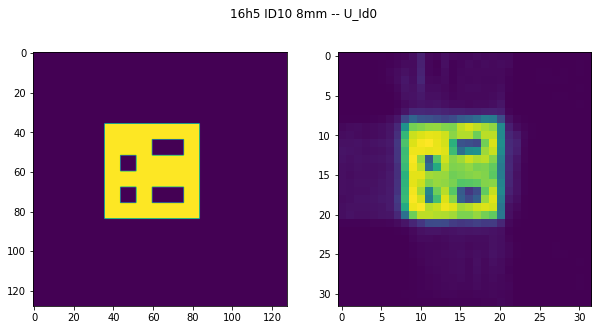

In [7]:
e = df.iloc[0]
fig, ax = plt.subplots(1,2, figsize=(10,5))
ax[0].imshow(e.Template)
ax[1].imshow(e.Simulation)
plt.suptitle(f"{e.MarkerType} ID{e.Id} {e.Size}mm -- U_Id{e.U_Id}")
plt.show()

# Filter only markers wanted in the Recognizer Model

In [8]:
print("Available Settings:")
print("Marker", df.MarkerType.unique())
print("Size", df.Size.unique())

Available Settings:
Marker ['16h5']
Size [8]


In [9]:
datasetsPaths = [f"{DATA_PATH}36h11_validation.pkl", f"{DATA_PATH}16h5_validation.pkl"]
lstdfs = []
for p in datasetsPaths:
    lstdfs.append(pd.read_pickle(p))
df_val = pd.concat(lstdfs)
df_val = df_val[df_val.MarkerType.isin(df.MarkerType.unique()) & df_val.Size.isin(df.Size.unique()) & df_val.Id.isin(df.Id.unique())]
df_val.reset_index(drop = True, inplace = True)

df_val['Angle'] = df_val.Angle.astype(np.float32)
df_val['AngleRad'] = np.radians(df_val['Angle'])
df_val['SinCos'] = df_val.AngleRad.apply(lambda e: (np.sin(e), np.cos(e)))
df_val['AngleDegNew'] = df_val.SinCos.apply(lambda x: np.rad2deg(np.arctan2(x[0],x[1])))

df_val['U_Id'] = df_val.apply(lambda r: uid[(r.MarkerType, r.Id, r.Size)], axis = 1)

df_val.groupby(["MarkerType", "Size"]).apply(lambda e: len(e.Id.unique())).reset_index().rename(columns = {0:"MarkerCount"})

df_val['U_Id_Group'] = df_val.U_Id.apply(lambda e: group_mapper[e])
df_val['Target'] = df_val.U_Id_Group.apply(lambda e: one_hot_targets[int(e)])

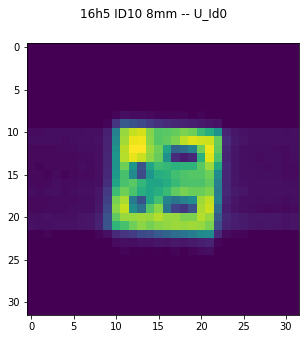

In [10]:
e = df_val.iloc[0]
fig, ax = plt.subplots(1,1, figsize=(10,5))
ax.imshow(e.Blob)
plt.suptitle(f"{e.MarkerType} ID{e.Id} {e.Size}mm -- U_Id{e.U_Id}")
plt.show()

In [11]:
# Set Hyperparamter for recognizer training

batch_size = 64
epochs = 10


# Split dataframe into train/val
index = list(df.index)
np.random.shuffle(index)

t_split = .8

idx_t = index[:int(t_split * len(index))]
idx_v = index[int(t_split * len(index)):]

df['Datatype'] = -1
df.loc[idx_t, 'Datatype'] = 'train'
df.loc[idx_v, 'Datatype'] = 'val'

# Init data generators for train and test using the simulator model
gen_train = DataGenerator(simulator, df[df.Datatype == 'train'], batch_size=batch_size)
gen_val = DataGenerator(simulator, df[df.Datatype == 'val'], batch_size=batch_size)

dataset_train = tf.data.Dataset.from_generator(gen_train, 
                                     output_signature=(
     tf.TensorSpec(shape=(batch_size, 32, 32, 1), dtype=tf.float32),
     (tf.TensorSpec(shape=(batch_size, nb_classes), dtype=tf.float32),
     tf.TensorSpec(shape=(batch_size, 2), dtype=tf.float32)))).prefetch(tf.data.AUTOTUNE)

dataset_val = tf.data.Dataset.from_generator(gen_val, 
                                     output_signature=(
     tf.TensorSpec(shape=(batch_size, 32, 32, 1), dtype=tf.float32),
     (tf.TensorSpec(shape=(batch_size, nb_classes), dtype=tf.float32),
     tf.TensorSpec(shape=(batch_size, 2), dtype=tf.float32)))).prefetch(tf.data.AUTOTUNE)

steps_train = len(df[df.Datatype == 'train'])//batch_size
steps_val = len(df[df.Datatype == 'val'])//batch_size

#train recognizer
classifier = recognizer.Recognizer(dataset_train, dataset_val, nb_classes, steps_train, steps_val)
history = classifier.train(batch_size = batch_size, epochs = epochs)

del gen_train
del gen_val

# test recognizer quality
x_val = np.stack((df_val.Blob/127.5 - 1.).values).reshape(-1,32,32,1)
y_class_true = np.argmax(np.stack(df_val.Target.values), axis = 1)

class_pred, rot_pred = classifier.model.predict(x_val)

class_pred = np.argmax(class_pred, axis = 1)

cm = confusion_matrix(y_class_true, class_pred, labels=range(nb_classes))
accuracy = accuracy_score(y_true=y_class_true, y_pred=class_pred)

rot_pred_rad = np.arctan2(rot_pred[:,0], rot_pred[:,1])
rot_true = rot_true = df_val.AngleRad.values
rot_error = np.rad2deg(((rot_pred_rad-rot_true + np.pi)%(2*np.pi))-np.pi)


res = {
    'Accuracy':accuracy,
    'Rotation_Errors':rot_error,
    'Confusion':cm
}

tensorflow verion: 2.9.1
Model: "recognizer"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input (InputLayer)             [(None, 32, 32, 1)]  0           []                               
                                                                                                  
 Conv0 (Conv2D)                 (None, 32, 32, 64)   640         ['input[0][0]']                  
                                                                                                  
 Conv1 (Conv2D)                 (None, 32, 32, 64)   36928       ['Conv0[0][0]']                  
                                                                                                  
 BatchNorm0 (BatchNormalization  (None, 32, 32, 64)  256         ['Conv1[0][0]']                  
 )                                                              

In [12]:
group_mapperT = dict((v,k) for k,v in group_mapper.items())
lstMarkerNames = []
for k in sorted(group_mapperT.keys()):
    x = re_uid[group_mapperT[k]]
    lstMarkerNames.append(f"{x[0]} ID{x[1]} {x[2]}mm")

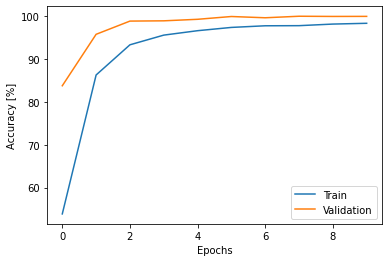

In [13]:
plt.plot(np.array(history.history["class_output_categorical_accuracy"])*100, label="Train")
plt.plot(np.array(history.history["val_class_output_categorical_accuracy"])*100, label="Validation")
plt.ylabel("Accuracy [%]")
plt.xlabel("Epochs")
plt.legend()

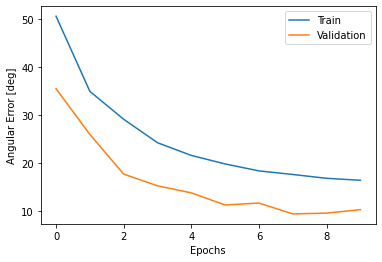

In [14]:
plt.plot(np.rad2deg(history.history["rot_output_angular_error"]), label="Train")
plt.plot(np.rad2deg(history.history["val_rot_output_angular_error"]), label="Validation")
plt.ylabel("Angular Error [deg]")
plt.xlabel("Epochs")
plt.legend()

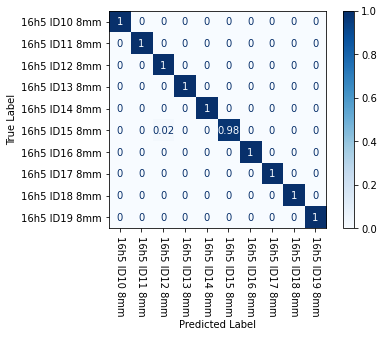

In [15]:
from sklearn.preprocessing import normalize
from sklearn.metrics import ConfusionMatrixDisplay

matrix = res["Confusion"]# confusion_matrix(res["Confusion"])
#matrix = df_results.iloc[0].Confusion
# array([[  0.,   3.,   6.],
#        [  9.,  12.,  15.],
#        [ 18.,  21.,  24.]])

normed_matrix = normalize(matrix, axis=1, norm='l1')
#fig, ax = plt.subplots(1, figsize = (20,20))
disp = ConfusionMatrixDisplay(confusion_matrix = normed_matrix.round(2), 
                              display_labels = lstMarkerNames)
disp.plot(cmap = plt.cm.Blues)
ax = disp.ax_
ax.set_xticks(np.arange(nb_classes))
#ax.set_yticklabels([re_uid[x] for x in df_results.iloc[-1].Classes])
ax.set_ylabel('True Label')
ax.set_xlabel('Predicted Label')

ax.set_xticklabels(lstMarkerNames, rotation = -90)
plt.show()